In [5]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
import plotly.graph_objs as go
import plotly.offline as py
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
import missingno as msno

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score 

In [343]:
df = pd.read_csv("../input/pima-indians-diabetes-database/diabetes.csv")

In [345]:
df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']] =  df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']].replace(0,np.NaN)

In [346]:
# msno.bar(df, figsize = (10,6))

In [347]:
df.isnull().sum().sort_values(ascending = False)

Insulin                     374
SkinThickness               227
BloodPressure                35
BMI                          11
Glucose                       5
Outcome                       0
Age                           0
DiabetesPedigreeFunction      0
Pregnancies                   0
dtype: int64

In [348]:
# msno.heatmap(df)

In [349]:
#Median fillnan system
def median_target(col):
    temp = df[df[col].notnull()]
    temp = temp[[col, "Outcome"]].groupby(["Outcome"])[[col]].median().reset_index()
    return temp
columns = df.columns
columns = columns.drop("Outcome")
for i in columns:
    median_target(i)
    df.loc[(df['Outcome'] == 0 ) & (df[i].isnull()), i] = median_target(i)[i][0]
    df.loc[(df['Outcome'] == 1 ) & (df[i].isnull()), i] = median_target(i)[i][1]

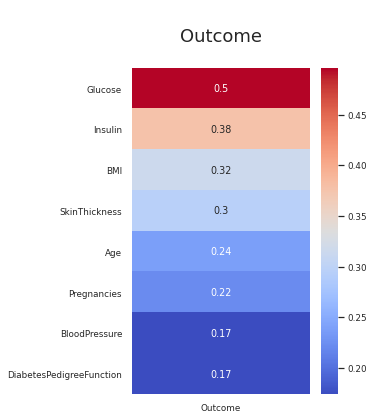

In [350]:
def corr_to_target(dataframe, target, title=None, file=None):
    plt.figure(figsize=(4,6))
    sns.heatmap(dataframe.corr()[[target]].sort_values(target,
                                                        ascending=False)[1:],
                                                        annot=True,
                                                        cmap='coolwarm')
    
    plt.title(f'\n{title}\n', fontsize=18)
    
    plt.show();
    
    return

corr_to_target(df, "Outcome", title="Outcome")

In [351]:
df.to_csv("diabetes_rep.csv", index = False)

Text(0.5, 1.0, 'Correlation Between Features')

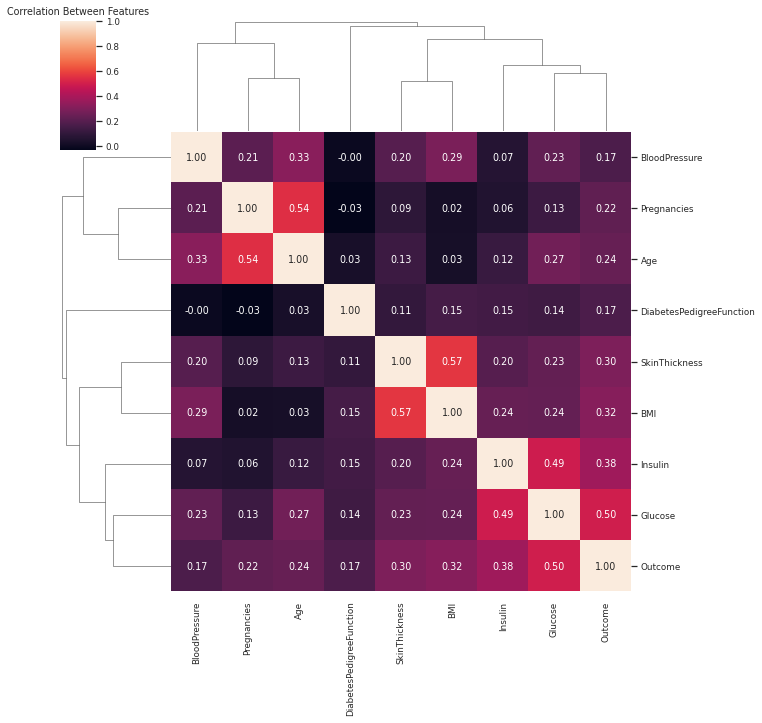

In [352]:
corr_matrix = df.corr()
sns.clustermap(corr_matrix, annot=True, fmt=".2f")
plt.title("Correlation Between Features")

In [353]:
df_orig = df.copy()

In [354]:
#####FEATURE SELECTION MODULE

In [355]:
from itertools import combinations 
from sklearn.preprocessing import PolynomialFeatures



#Input data structure: train+test+target
#Processing all but target

# df = pd.read_csv(config.INPUT_FILE)
#Selecciona todas las cols excepto target
df_sel = df.loc[:, df.columns != "Outcome"]

#Splitting cat and nums
cat_feats = df_sel.select_dtypes(include= object).columns
num_feats = df_sel.select_dtypes(exclude = object).columns


print("Initial features:", df_sel.shape[1])
print("Cat feats:", cat_feats)
print("Num feats:", num_feats)


#Categorical processing
# Crear combinaciones de categoricals
pairs = list(combinations(cat_feats, 2))
for pair in pairs:
    df_sel[pair[0] + "_" + pair[1]] = df_sel[pair[0]].astype(str)+ "_" 
    + df_sel[pair[1]].astype(str)


print("Total new features after cat combinations:", df_sel.shape[1])




# #PART 2: #Create new numerical feats: binning, polynomial feats

# #binning


# Polynomial regressor of order 3 with ConstructArea (1,a,a2,a3)
print("Polynomial regressor of order 2:")
poly_2 = PolynomialFeatures(degree=2, interaction_only=False,
include_bias=False) #instanciamos
poly = poly_2.fit_transform(df_sel[num_feats]) # se crean todos los features nuevo
col_poly = ["poly" + str(i) for i in range(poly.shape[1])]
df_poly = pd.DataFrame(poly, columns = col_poly)

print("Total num features after 2nd order poly creation:", df_poly.shape[1])
#Get back together with target
df = pd.concat((df["Outcome"], df_sel, df_poly), axis = 1)


#Save the data with new features
df.to_csv("data_feat_gen.csv", index  = False)
print("Final features:", df.shape[1])
print("Final columns:", df.columns)
print(df.head(5))

Initial features: 8
Cat feats: Index([], dtype='object')
Num feats: Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')
Total new features after cat combinations: 8
Polynomial regressor of order 2:
Total num features after 2nd order poly creation: 44
Final features: 53
Final columns: Index(['Outcome', 'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
       'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'poly0', 'poly1',
       'poly2', 'poly3', 'poly4', 'poly5', 'poly6', 'poly7', 'poly8', 'poly9',
       'poly10', 'poly11', 'poly12', 'poly13', 'poly14', 'poly15', 'poly16',
       'poly17', 'poly18', 'poly19', 'poly20', 'poly21', 'poly22', 'poly23',
       'poly24', 'poly25', 'poly26', 'poly27', 'poly28', 'poly29', 'poly30',
       'poly31', 'poly32', 'poly33', 'poly34', 'poly35', 'poly36', 'poly37',
       'poly38', 'poly39', 'poly40', 'poly41', 'poly42', 'poly43'],
      

In [356]:
df_feat = df.copy()
df.head()

,Outcome,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,poly0,...,poly34,poly35,poly36,poly37,poly38,poly39,poly40,poly41,poly42,poly43
0,1,6,148.0,72.0,35.0,169.5,33.6,0.627,50,6.0,...,28730.25,5695.20,106.2765,8475.0,1128.96,21.0672,1680.0,0.393129,31.350,2500.0
1,0,1,85.0,66.0,29.0,102.5,26.6,0.351,31,1.0,...,10506.25,2726.50,35.9775,3177.5,707.56,9.3366,824.6,0.123201,10.881,961.0
2,1,8,183.0,64.0,32.0,169.5,23.3,0.672,32,8.0,...,28730.25,3949.35,113.9040,5424.0,542.89,15.6576,745.6,0.451584,21.504,1024.0
3,0,1,89.0,66.0,23.0,94.0,28.1,0.167,21,1.0,...,8836.00,2641.40,15.6980,1974.0,789.61,4.6927,590.1,0.027889,3.507,441.0
4,1,0,137.0,40.0,35.0,168.0,43.1,2.288,33,0.0,...,28224.00,7240.80,384.3840,5544.0,1857.61,98.6128,1422.3,5.234944,75.504,1089.0


In [306]:
df2 = df.copy()

In [307]:
##0. Baseline score
target = "Outcome"
def baseline(df):
    target = "Outcome"
    X = df.copy()
    y = X.pop(target)
    scaler = StandardScaler().fit(X)
    XRescaled = scaler.transform(X)
    lr = LogisticRegression(max_iter= 50000)
    kfold = StratifiedKFold(n_splits = 10)
    cv_results = cross_val_score(estimator = lr, X = XRescaled, y = y, scoring = "accuracy", cv = kfold)
    msg = "%s: %f (%f)" % ("Modelo", cv_results.mean(), cv_results.std()) 
    return msg

baseline(df)

'Modelo: 0.830793 (0.034781)'

In [308]:
#1. AMOUNT OF VARIATION: remove features with very low variance (close to zero)


In [53]:
krt = pd.read_csv("../input/train-kort/train_kortical.csv")
krt.head()

,Survived,Pclass,SibSp,Parch,Fare,port_sex,Age_bin,Ticket_freq,poly1,poly2,...,50,51,52,53,57,58,59,60,61,62
0,0,3,1,0,7,623,2,1,3.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,1,1,1,0,71,113,7,2,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,3,0,0,7,293,4,1,3.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,1,1,1,0,53,293,6,2,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,3,0,0,8,623,6,1,3.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [310]:
for col in krt.columns:
    print(krt[col].std())

0.4865924542648585
0.8360712409770513
1.1027434322934275
0.8060572211299559
49.703729610662066
224.04177271946017
2.902105645565373
1.7966601633571486
0.8360712409770513
1.1027434322934275
0.8060572211299559
49.703729610662066
401.6417841288048
224.04177271946017
2.902105645565373
1.7966601633571486
237071.52273058955
735.4218898548165
577.327071354165
27582.53571832084
291359.2647052091
157634.9058033659
1880.3560528243736
1094.4642335552282
3.4436553842652375
3.1872570176305492
2.13132625575468
51.71145114964638
1217.1023104287037
670.4621113076786
7.032727904686723
5.139558294105141
6.3938722650892075
1.9792865515522744
79.09039420253771
1097.7066743372336
541.1489819295447
9.268323864722207
331.2001511972668
4.73979406074853
17296.183868346594
26332.32606419853
15397.435062450311
309.5727431353561
241.07989774880915
430487.9515327122
263942.9684919818
2947.817826805455
1884.2988279690194
172553.67638129985
1679.8119964550626
968.2958890719036
26.800281579681638
10.084170789446466
1

In [311]:
from sklearn.feature_selection import VarianceThreshold

#Rescale data if necessary
target = "Survived"
X2 = krt.copy()
y2 = X2.pop(target)
scaler = StandardScaler().fit(X2)
XRescaled = scaler.transform(X2)
X_rescaled = pd.DataFrame(XRescaled, columns = X2.columns)

#Analysis of amount of variation and droping all features with low variance
var_tresh = VarianceThreshold(threshold = 0.1)
transformed_data = var_tresh.fit_transform(X_rescaled)
print("Shape of transformed:", transformed_data.shape)
X_df = pd.DataFrame(transformed_data, columns = X2.columns) #reconvert new X to df

#Rejoin
df = pd.concat((y2, X_df), axis = 1)



Shape of transformed: (891, 105)


In [312]:
df.columns, df.shape

(Index(['Survived', 'Pclass', 'SibSp', 'Parch', 'Fare', 'port_sex', 'Age_bin',
        'Ticket_freq', 'poly1', 'poly2',
        ...
        '50', '51', '52', '53', '57', '58', '59', '60', '61', '62'],
       dtype='object', length=106),
 (891, 106))

In [313]:
baseline(df)

KeyError: 'Outcome'

In [314]:
#2. HIGH CORRELATION WITH TARGET:
#Modulo: General summary of dataset
def summary_2(df, target):
    num = df.select_dtypes(exclude= object).columns
    cols = ["Correlation"]
    ind = df.columns
    dict = {}
   
    dict["Correlation"] = np.round(df.corr()[target], decimals = 3)
    summary = pd.DataFrame(dict, columns = cols, index = ind)
    return summary

sum = summary_2(df, "Outcome").sort_values(by = "Correlation", ascending = False)
##Features with the highest correlations (50)
sum.sort_values(by = "Correlation", ascending = False)[:15]

KeyError: 'Outcome'

In [ ]:
#3. CORRELATION BETWEEN FEATURES
# corr_matrix = df.corr()
# sns.clustermap(corr_matrix, annot=True, fmt=".2f")
# plt.title("Correlation Between Features")

def feat_corr(df, target):
    for i in df.index:
        cols = list(set(df.index) - set([i]))
        maximo = np.abs(df.loc[i, cols]).max()
        for c in cols:
            name_max = "None"
            if np.abs(df.loc[i, c]) == maximo:
                name_max = c
                df.loc[i, "Feature_w_max_corr"] = c
                df.loc[i, "Max_correlation"] = df.loc[i, c] 
                df.loc[i, "F1_corr_Target"] = df.loc[i, target]
                df.loc[i, "F2_corr_Target"] = df.loc[c, target]
                if np.abs(df.loc[i, "F1_corr_Target"]) > np.abs(df.loc[i, "F2_corr_Target"]):
                    df.loc[i, "Dropable"] = c
                elif  np.abs(df.loc[i, "F1_corr_Target"]) < np.abs(df.loc[i, "F2_corr_Target"]):
                    df.loc[i, "Dropable"] = i
                else:
                    df.loc[i, "Dropable"] = i
                    
    summary =  df[["Feature_w_max_corr", "Max_correlation", "F1_corr_Target", "F2_corr_Target", "Dropable"]].sort_values(by = "F1_corr_Target", ascending = False)
#     sum_final = summary[(abs(summary["F1_corr_Target"]) > 0.26) & (abs(summary["F2_corr_Target"]) > 0.26)]
    sum_final = summary[(abs(summary["Max_correlation"]) > 0.75) ]

    dropables = list(sum_final["Dropable"].unique())
    return sum_final, dropables

sum_final, dropables = feat_corr(df.corr(), target)

sum_final.sort_values(by="Max_correlation", ascending = False)

In [ ]:
def calcDrop(res):
    # All variables with correlation > cutoff
    all_corr_vars = list(set(res['v1'].tolist() + res['v2'].tolist()))
    
    # All unique variables in drop column
    poss_drop = list(set(res['drop'].tolist()))

    # Keep any variable not in drop column
    keep = list(set(all_corr_vars).difference(set(poss_drop)))
     
    # Drop any variables in same row as a keep variable
    p = res[ res['v1'].isin(keep)  | res['v2'].isin(keep) ][['v1', 'v2']]
    q = list(set(p['v1'].tolist() + p['v2'].tolist()))
    drop = (list(set(q).difference(set(keep))))

    # Remove drop variables from possible drop 
    poss_drop = list(set(poss_drop).difference(set(drop)))
    
    # subset res dataframe to include possible drop pairs
    m = res[ res['v1'].isin(poss_drop)  | res['v2'].isin(poss_drop) ][['v1', 'v2','drop']]
        
    # remove rows that are decided (drop), take set and add to drops
    more_drop = set(list(m[~m['v1'].isin(drop) & ~m['v2'].isin(drop)]['drop']))
    for item in more_drop:
        drop.append(item)
         
    return drop

def corrX_new(df, cut = 0.9) :
       
    # Get correlation matrix and upper triagle
    corr_mtx = df.corr().abs()
    avg_corr = corr_mtx.mean(axis = 1)
    up = corr_mtx.where(np.triu(np.ones(corr_mtx.shape), k=1).astype(np.bool))
    
    dropcols = list()
    
    res = pd.DataFrame(columns=(['v1', 'v2', 'v1.target', 
                                 'v2.target','corr', 'drop' ]))
    
    for row in range(len(up)-1):
        col_idx = row + 1
        for col in range (col_idx, len(up)):
            if(corr_mtx.iloc[row, col] > cut):
                if(avg_corr.iloc[row] > avg_corr.iloc[col]): 
                    dropcols.append(row)
                    drop = corr_mtx.columns[row]
                else: 
                    dropcols.append(col)
                    drop = corr_mtx.columns[col]
                
                s = pd.Series([ corr_mtx.index[row],
                up.columns[col],
                avg_corr[row],
                avg_corr[col],
                up.iloc[row,col],
                drop],
                index = res.columns)
        
                res = res.append(s, ignore_index = True)
    
    dropcols_names = calcDrop(res)
    
    return(dropcols_names)

In [ ]:
corrX_new(krt, cut = 0.9)

In [ ]:
krt.drop(corrX_new(df, cut = 0.9), axis = 1, inplace = True)

In [ ]:
baseline(df)

In [ ]:
df4 = df.copy()

In [ ]:
sum_final, dropables = feat_corr(df.corr(), target)
sum_final.sort_values(by="Max_correlation", ascending = False)

In [ ]:
df.drop(["poly2", "poly16", "poly38", "poly43", "Pregnancies"], axis = 1, inplace = True)

In [ ]:
baseline(df)

In [ ]:
sum_final, dropables = feat_corr(df.corr(), target)
sum_final.sort_values(by="Max_correlation", ascending = False)

In [ ]:
df.drop(["poly23", "Insulin","DiabetesPedigreeFunction", "poly10" ], axis = 1, inplace = True)

In [ ]:
baseline(df)

In [ ]:
sum_final, dropables = feat_corr(df.corr(), target)
sum_final.sort_values(by="Max_correlation", ascending = False)

In [ ]:
df.drop(dropables, axis = 1, inplace = True)

In [315]:
baseline(df)

KeyError: 'Outcome'

In [316]:
sum_final, dropables = feat_corr(df.corr(), target)
sum_final.sort_values(by="Max_correlation", ascending = False)

,Feature_w_max_corr,Max_correlation,F1_corr_Target,F2_corr_Target,Dropable
16,60,1.0,-0.549199,-0.549199,16
3,35,1.0,0.003650,0.003650,3
53,44,1.0,0.145321,0.145321,53
51,7,1.0,0.114652,0.114652,51
7,51,1.0,0.114652,0.114652,7
...,...,...,...,...,...
23,26,-1.0,0.543351,-0.543351,23
26,29,-1.0,-0.543351,0.543351,26
25,26,-1.0,0.543351,-0.543351,25
0,26,-1.0,0.543351,-0.543351,0


In [317]:
df.drop(dropables, axis = 1, inplace = True)

In [318]:
df.head()

,Survived,poly14,poly15,poly16,poly17,poly18,poly21,poly22,poly23,poly26,...,poly48,poly49,poly50,poly52,5,20,21,22,46,62
0,0,-1.207622,-1.161199,-1.066886,-0.861284,0.863504,-0.571347,0.792535,1.357727,-0.076400,...,0.998919,-0.344215,-0.223420,-0.657464,-0.130856,-0.169907,-0.208148,1.432260,-0.067153,-0.162781
1,1,-1.210459,-1.163719,-1.060501,-0.858542,-1.460913,0.396099,-1.630972,-1.262833,-0.076400,...,-1.177626,-0.615231,-0.633649,0.533188,-0.130856,-0.169907,-0.208148,1.432260,-0.067153,-0.162781
2,1,-1.200658,-1.159574,-1.061565,-0.859456,0.863504,-0.571347,0.792535,-0.119696,-0.232887,...,-0.753868,-0.388292,-0.564417,-0.459022,-0.130856,-0.169907,-0.208148,-0.698197,-0.067153,-0.162781
3,1,-1.209813,-1.157715,-1.055180,-0.854885,-1.460913,0.047819,-1.630972,-0.994211,-0.076400,...,-0.753868,-0.039248,-0.261653,0.334746,-0.130856,-0.169907,-0.208148,1.432260,-0.067153,-0.162781
4,0,-1.193693,-1.145382,-1.051987,-0.857627,0.863504,-0.513301,0.792535,1.357727,-0.232887,...,0.998919,1.140117,-0.223420,-0.260580,-0.130856,-0.169907,-0.208148,-0.698197,-0.067153,-0.162781


In [319]:
baseline(df)

KeyError: 'Outcome'

In [320]:
sum_final, dropables = feat_corr(df.corr(), target)
sum_final.sort_values(by="Max_correlation", ascending = False)

,Feature_w_max_corr,Max_correlation,F1_corr_Target,F2_corr_Target,Dropable
poly18,poly22,0.905816,-0.339693,-0.358245,poly18
poly22,poly18,0.905816,-0.358245,-0.339693,poly18
poly44,poly22,0.902197,-0.316983,-0.358245,poly44
poly26,poly29,0.888654,-0.094248,-0.103258,poly26
poly29,poly26,0.888654,-0.103258,-0.094248,poly26
poly30,poly29,0.872947,-0.098408,-0.103258,poly30
poly48,poly23,0.835287,-0.402878,-0.430316,poly48
poly23,poly48,0.835287,-0.430316,-0.402878,poly48
poly47,poly29,0.754798,-0.116742,-0.103258,poly29


In [321]:
df.head()

,Survived,poly14,poly15,poly16,poly17,poly18,poly21,poly22,poly23,poly26,...,poly48,poly49,poly50,poly52,5,20,21,22,46,62
0,0,-1.207622,-1.161199,-1.066886,-0.861284,0.863504,-0.571347,0.792535,1.357727,-0.076400,...,0.998919,-0.344215,-0.223420,-0.657464,-0.130856,-0.169907,-0.208148,1.432260,-0.067153,-0.162781
1,1,-1.210459,-1.163719,-1.060501,-0.858542,-1.460913,0.396099,-1.630972,-1.262833,-0.076400,...,-1.177626,-0.615231,-0.633649,0.533188,-0.130856,-0.169907,-0.208148,1.432260,-0.067153,-0.162781
2,1,-1.200658,-1.159574,-1.061565,-0.859456,0.863504,-0.571347,0.792535,-0.119696,-0.232887,...,-0.753868,-0.388292,-0.564417,-0.459022,-0.130856,-0.169907,-0.208148,-0.698197,-0.067153,-0.162781
3,1,-1.209813,-1.157715,-1.055180,-0.854885,-1.460913,0.047819,-1.630972,-0.994211,-0.076400,...,-0.753868,-0.039248,-0.261653,0.334746,-0.130856,-0.169907,-0.208148,1.432260,-0.067153,-0.162781
4,0,-1.193693,-1.145382,-1.051987,-0.857627,0.863504,-0.513301,0.792535,1.357727,-0.232887,...,0.998919,1.140117,-0.223420,-0.260580,-0.130856,-0.169907,-0.208148,-0.698197,-0.067153,-0.162781


In [322]:
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier,GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC 
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from catboost import CatBoostClassifier

import numpy as np


def run_cv(models, X, y):
    kfold = StratifiedKFold(n_splits= 10) #must be equal to FOLDS
    dict = {"Algorithm":[], "Model_detail":[], "Score":[], 
    "Std_Error": []}
    report = pd.DataFrame(dict)

    for model in models:
        mod = models[model]
        cv_results = cross_val_score(estimator = models[model],
        X= X , y = y, scoring = scoring, cv = kfold)
        report  = report.append({"Algorithm":model,"Model_detail": mod,
         "Score": cv_results.mean(),
            "Std_Error":cv_results.std()}, 
            ignore_index = True)
    print(report[["Algorithm", "Score", "Std_Error"]].sort_values(by = "Score", 
    ascending = False))
    
   

if __name__ == "__main__":
    target = "Survived"
    num_folds = 10
    seed = 42
    X = krt.copy()
    y = X.pop(target)
    scaler = StandardScaler().fit(X)
    XRescaled = scaler.transform(X)
    scoring = "accuracy"
    models =    {
    "decision_tree_gini":tree.DecisionTreeClassifier(criterion= "gini", random_state = 42),
    "decision_tree_entropy": tree.DecisionTreeClassifier(criterion= "entropy",  random_state = 42),
    "RandomForest": RandomForestClassifier(random_state = 42),
    "ExtraTrees": ExtraTreesClassifier(random_state = 42),
    # "GradientBoosting":GradientBoostingClassifier(random_state = 42),
    "CatBoostClassifier": CatBoostClassifier(random_state = 42, verbose = 0),
    'SVM': SVC(),
    'LinearDiscriminant': LinearDiscriminantAnalysis(),
    "KNearest_Neighbour": KNeighborsClassifier(),
    'LogisticRegression': LogisticRegression(max_iter = 40000)}
    print("UNIFIED BASELINE RESULTS:")
#     run_cv(models, XRescaled, y)
    






UNIFIED BASELINE RESULTS:


In [323]:
target

'Survived'

In [324]:
# X = krt.copy()
# y = X.pop(target)
# scaler = StandardScaler().fit(X)
# XRescaled = scaler.transform(X)

# kfold = StratifiedKFold(n_splits= 10)
# mod = SVC()
# mod_params = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
# gs_mod = GridSearchCV(mod, param_grid = mod_params, cv = kfold,
#          scoring = "accuracy",
#                         n_jobs = -1, verbose = 0)
# gs_mod.fit(XRescaled, y)
# gs_best = gs_mod.best_estimator_
# print("Best Score:", gs_mod.best_score_)


In [327]:
# ##TUNING

# import os

# import argparse 
# import glob

# import joblib
# import pandas as pd 
# from sklearn import metrics
# from sklearn import tree 
# import numpy as np

# from sklearn.datasets import make_classification
# from sklearn.model_selection import train_test_split

# from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

# #Algorithms to work with
# from sklearn import tree
# from sklearn.ensemble import RandomForestClassifier 
# from sklearn.ensemble import ExtraTreesClassifier,GradientBoostingClassifier
# from sklearn.ensemble import AdaBoostClassifier



# def run_tuning(models, X, y):
#     kfold = StratifiedKFold(n_splits= 10) #must be equal to FOLDS
#     dict = {"Algorithm":[], "Model_detail":[], "Best Score":[], 
#     "Std_test_score": []}
#     report = pd.DataFrame(dict)

#     for model in models:
#         print(model)
#         print(models[model])
#         mod = models[model]
#         mod_params = model_dispatcher.model_param[model]
#         gs_mod = GridSearchCV(mod, param_grid = mod_params, cv = kfold,
#          scoring = "accuracy",
#                         n_jobs = -1, verbose = 0)
#         gs_mod.fit(X, y)
#         gs_best = gs_mod.best_estimator_
#         #Save the model
#         joblib.dump(gs_mod, os.path.join(config.MODEL_OUTPUT,
#          f"../models/model_{model}.bin"))
#         report  = report.append({"Algorithm":model, "Model_detail": gs_mod,
#             "Best Score":gs_mod.best_score_, 
#             "Std_test_score": gs_mod.cv_results_["std_test_score"].mean()},
#             ignore_index = True)
#     print(report[["Algorithm", "Best Score", "Std_test_score"]].sort_values(by = "Best Score", ascending = False))
    
#     #Save the best 3 algorithms
#     best = report.sort_values(by = "Best Score", ascending = False).head(4)
#     # best_models = best["Model_detail"].values
#     for model, name in zip(best["Model_detail"], best["Algorithm"]):
#         joblib.dump(model, os.path.join(config.BEST_MODELS,
#          f"model_{name}.bin"))
    
   


# if __name__ == "__main__":
#     files = glob.glob("../models/bestModels/*")
#     for f in files:
#         os.remove(f)
#     target = config.TARGET
#     num_folds = config.FOLDS
#     seed = config.SEED
#     X_train =  pd.read_csv("../input/X_train.csv")
#     y_train =  pd.read_csv("../input/y_train.csv").values.ravel()
#     scoring = config.SCORING
#     models = model_dispatcher.MODELS
#     print("MODEL TUNING RESULTS:")
#     run_tuning(models, X_train, y_train)


In [328]:
#Creating the correlation df

def corr_heat(df):
    corr = df.corr()
    top_corr_cols = corr[abs((corr.Outcome) < 0.30)].Outcome.sort_values(ascending = False).keys() #keys is colmns for Series
    top_corr = corr.loc[top_corr_cols, top_corr_cols] #creo una matrix que muestra correlaciones entre los miembros de este subset

    #creating the plot
    dropSelf = np.zeros_like(top_corr) #crea una matrix de zeros con shape igual a top_corr
    dropSelf[np.triu_indices_from(dropSelf)] = True
    plt.figure(figsize = (25,25))
    sns.heatmap(top_corr, cmap = sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f", mask = dropSelf)
    sns.set(font_scale =0.8)
    plt.show()
    
corr_heat(df)

AttributeError: 'DataFrame' object has no attribute 'Outcome'

In [ ]:
corr_heat(df)

In [ ]:
def corr_heat_2(df, target):
    corr = df.corr()
    top_corr_cols = corr[abs((corr[target]) > 0.20)][target].sort_values(ascending = False).keys() #keys is colmns for Series
    top_corr = corr.loc[top_corr_cols, top_corr_cols] #creo una matrix que muestra correlaciones entre los miembros de este subset

    #creating the plot
    dropSelf = np.zeros_like(top_corr) #crea una matrix de zeros con shape igual a top_corr
    dropSelf[np.triu_indices_from(dropSelf)] = True
    plt.figure(figsize = (25,25))
    sns.heatmap(top_corr, cmap = sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f", mask = dropSelf)
    sns.set(font_scale =0.8)
    plt.show()
    

In [ ]:
corr_heat_2(df)

In [ ]:
df.drop(["poly1", "poly25", "poly4", "poly5", "BMI"], axis =1, inplace = True)

In [ ]:
baseline(df)

In [ ]:
corr_heat_2(df)

In [ ]:
def feat_corr(df, target):
    for i in df.index:
        cols = list(set(df.index) - set([i]))
        maximo = np.abs(df.loc[i, cols]).max()
        for c in cols:
            name_max = "None"
            if np.abs(df.loc[i, c]) == maximo:
                name_max = c
                df.loc[i, "Feature_w_max_corr"] = c
                df.loc[i, "Max_correlation"] = df.loc[i, c] 
                df.loc[i, "F1_corr_Target"] = df.loc[i, target]
                df.loc[i, "F2_corr_Target"] = df.loc[c, target]
                if np.abs(df.loc[i, "F1_corr_Target"]) > np.abs(df.loc[i, "F2_corr_Target"]):
                    df.loc[i, "Dropable"] = c
                elif  np.abs(df.loc[i, "F1_corr_Target"]) < np.abs(df.loc[i, "F2_corr_Target"]):
                    df.loc[i, "Dropable"] = i
                else:
                    df.loc[i, "Dropable"] = i
                    
    summary =  df[["Feature_w_max_corr", "Max_correlation", "F1_corr_Target", "F2_corr_Target", "Dropable"]].sort_values(by = "F1_corr_Target", ascending = False)
#     sum_final = summary[(abs(summary["F1_corr_Target"]) > 0.26) & (abs(summary["F2_corr_Target"]) > 0.26)]
    sum_final = summary[(abs(summary["Max_correlation"]) > 0.75) ]

    dropables = list(sum_final["Dropable"].unique())
    return sum_final, dropables

sum_final, dropables = feat_corr(df.corr(), target)

sum_final

In [ ]:
df.corr()

In [ ]:
df.head()

In [ ]:
df.corr().abs()

In [ ]:
df.corr()

In [ ]:
def corrX_orig(df, cut = 0.9) :
        
    # Get correlation matrix and upper triagle
    corr_mtx = df.corr().abs()
    avg_corr = corr_mtx.mean(axis = 1)
    up = corr_mtx.where(np.triu(np.ones(corr_mtx.shape), k=1).astype(np.bool))
    
    drop = list()

        
    # For loop implements this pseudocode
    # For every cell in the upper triangle: 
        # If cell.value > 0.6: 
                # If mean(row_correlation) > mean(column_correlation):drop(column)
		# Else: drop(row)
    for row in range(len(up)-1):
        col_idx = row + 1
        for col in range (col_idx, len(up)):
            if(corr_mtx.iloc[row, col] > cut):
                if(avg_corr.iloc[row] > avg_corr.iloc[col]): 
                    drop.append(row)
                else: 
                    drop.append(col)
    
    drop_set = list(set(drop))
    # dropcols_idx = drop_set
    dropcols_names = list(df.columns[[item for item in drop_set]])
    return dropcols_names

In [ ]:
corrX_orig(df, cut = 0.9)

In [329]:
df.head()

,Survived,poly14,poly15,poly16,poly17,poly18,poly21,poly22,poly23,poly26,...,poly48,poly49,poly50,poly52,5,20,21,22,46,62
0,0,-1.207622,-1.161199,-1.066886,-0.861284,0.863504,-0.571347,0.792535,1.357727,-0.076400,...,0.998919,-0.344215,-0.223420,-0.657464,-0.130856,-0.169907,-0.208148,1.432260,-0.067153,-0.162781
1,1,-1.210459,-1.163719,-1.060501,-0.858542,-1.460913,0.396099,-1.630972,-1.262833,-0.076400,...,-1.177626,-0.615231,-0.633649,0.533188,-0.130856,-0.169907,-0.208148,1.432260,-0.067153,-0.162781
2,1,-1.200658,-1.159574,-1.061565,-0.859456,0.863504,-0.571347,0.792535,-0.119696,-0.232887,...,-0.753868,-0.388292,-0.564417,-0.459022,-0.130856,-0.169907,-0.208148,-0.698197,-0.067153,-0.162781
3,1,-1.209813,-1.157715,-1.055180,-0.854885,-1.460913,0.047819,-1.630972,-0.994211,-0.076400,...,-0.753868,-0.039248,-0.261653,0.334746,-0.130856,-0.169907,-0.208148,1.432260,-0.067153,-0.162781
4,0,-1.193693,-1.145382,-1.051987,-0.857627,0.863504,-0.513301,0.792535,1.357727,-0.232887,...,0.998919,1.140117,-0.223420,-0.260580,-0.130856,-0.169907,-0.208148,-0.698197,-0.067153,-0.162781


In [330]:
df["nuevo1"] = 1
df["nuevo2"] = 0

In [331]:
df.nuevo1

0      1
1      1
2      1
3      1
4      1
      ..
886    1
887    1
888    1
889    1
890    1
Name: nuevo1, Length: 891, dtype: int64

In [404]:

##MODULE 1: VARIANCE THRESHOLD FEATURE SELECTION
from sklearn.feature_selection import VarianceThreshold

def variance_selector(df, target):
#Rescale data if necessary
    print("Variance Threshold feature selection:")
    print("")
    X2 = df.copy()
    y2 = X2.pop(target)
    print("Initial feats:", X2.shape[1])
    low = [col for col in X2.columns if X2[col].std() < 0.5]
    print("Estos son antes de escale:", low)
    scaler = StandardScaler().fit(X2)
    XRescaled = scaler.transform(X2)
    X_rescaled = pd.DataFrame(XRescaled, columns = X2.columns)
    low = [col for col in X_rescaled.columns if X_rescaled[col].std() < 0.5]
    print("Estos son despues de escale:", low)
    #Analysis of amount of variation and droping all features with low variance
    var_tresh = VarianceThreshold(threshold = 0.5)
    var_tresh.fit_transform(X_rescaled)
    data_transformed = X2.loc[:, var_tresh.get_support()]
    print("Selected feats:", data_transformed.columns)
    print("Removed features:", set(X2.columns) - set(data_transformed.columns))
    print("Final features:", data_transformed.shape[1])
    print("{} features with low variance removed".format(X2.shape[1] - data_transformed.shape[1]))
    #Rejoin
    df = pd.concat((y2, data_transformed), axis = 1)
    return df

In [405]:
variance_selector(krt, target)

Variance Threshold feature selection:

Initial feats: 108
Estos son antes de escale: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '13', '14', '15', '16', '17', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '39', '41', '42', '43', '44', '46', '48', '50', '51', '52', '53', '57', '58', '59', '60', '61', '62', 'new1', 'new2', 'new3']
Estos son despues de escale: ['new1', 'new2', 'new3']
Selected feats: Index(['Pclass', 'SibSp', 'Parch', 'Fare', 'port_sex', 'Age_bin',
       'Ticket_freq', 'poly1', 'poly2', 'poly3',
       ...
       '50', '51', '52', '53', '57', '58', '59', '60', '61', '62'],
      dtype='object', length=105)
Removed features: {'new2', 'new3', 'new1'}
Final features: 105
3 features with low variance removed


,Survived,Pclass,SibSp,Parch,Fare,port_sex,Age_bin,Ticket_freq,poly1,poly2,...,50,51,52,53,57,58,59,60,61,62
0,0,3,1,0,7,623,2,1,3.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,1,1,1,0,71,113,7,2,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,3,0,0,7,293,4,1,3.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,1,1,1,0,53,293,6,2,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,3,0,0,8,623,6,1,3.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,0,0,13,623,4,1,2.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
887,1,1,0,0,30,293,1,1,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
888,0,3,1,2,23,293,3,4,3.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
889,1,1,0,0,30,157,4,1,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [65]:
###MODULO 2: REMOVAL OF HIGHEST CORRELATIONS
def calcDrop(res):
    # All variables with correlation > cutoff
    all_corr_vars = list(set(res['v1'].tolist() + res['v2'].tolist()))
    
    # All unique variables in drop column
    poss_drop = list(set(res['drop'].tolist()))

    # Keep any variable not in drop column
    keep = list(set(all_corr_vars).difference(set(poss_drop)))
     
    # Drop any variables in same row as a keep variable
    p = res[ res['v1'].isin(keep)  | res['v2'].isin(keep) ][['v1', 'v2']]
    q = list(set(p['v1'].tolist() + p['v2'].tolist()))
    drop = (list(set(q).difference(set(keep))))

    # Remove drop variables from possible drop 
    poss_drop = list(set(poss_drop).difference(set(drop)))
    
    # subset res dataframe to include possible drop pairs
    m = res[ res['v1'].isin(poss_drop)  | res['v2'].isin(poss_drop) ][['v1', 'v2','drop']]
        
    # remove rows that are decided (drop), take set and add to drops
    more_drop = set(list(m[~m['v1'].isin(drop) & ~m['v2'].isin(drop)]['drop']))
    for item in more_drop:
        drop.append(item)
         
    return drop

def corrX_new(df, cut = 0.65) :
       
    # Get correlation matrix and upper triagle
    corr_mtx = df.corr().abs()
    avg_corr = corr_mtx.mean(axis = 1)
    up = corr_mtx.where(np.triu(np.ones(corr_mtx.shape), k=1).astype(np.bool))
    
    dropcols = list()
    
    res = pd.DataFrame(columns=(['v1', 'v2', 'v1.target', 
                                 'v2.target','corr', 'drop' ]))
    
    for row in range(len(up)-1):
        col_idx = row + 1
        for col in range (col_idx, len(up)):
            if(corr_mtx.iloc[row, col] > cut):
                if(avg_corr.iloc[row] > avg_corr.iloc[col]): 
                    dropcols.append(row)
                    drop = corr_mtx.columns[row]
                else: 
                    dropcols.append(col)
                    drop = corr_mtx.columns[col]
                
                s = pd.Series([ corr_mtx.index[row],
                up.columns[col],
                avg_corr[row],
                avg_corr[col],
                up.iloc[row,col],
                drop],
                index = res.columns)
        
                res = res.append(s, ignore_index = True)
    
    dropcols_names = calcDrop(res)
    print("{} features removed".format(len(dropcols_names)))
    print("Features removed:", dropcols_names)
    print("Selected features:", df.shape[1] - len(dropcols_names))
    selected_cols = set(df.columns) - set(dropcols_names)
    print("Selected:", selected_cols)
    return df[selected_cols]

In [66]:
corrX_new(krt, cut = 0.65)

75 features removed
Features removed: ['13', 'poly51', '25', 'SibSp', 'poly7', '42', 'Fare', '44', 'poly26', '26', 'poly14', 'poly53', '58', 'poly2', '43', '35', 'poly3', 'poly13', '24', '41', '19', '1', 'poly27', '32', '30', '51', '33', '57', 'poly42', 'poly38', 'poly5', '39', '4', 'poly17', 'poly4', 'poly30', 'poly10', 'poly22', '50', '0', 'poly43', '52', 'poly1', 'Age_bin', '23', '34', '53', '28', 'poly32', '61', 'poly20', 'poly44', '36', 'Pclass', '48', '59', 'poly19', 'poly15', 'poly29', 'poly21', '31', '27', 'Parch', '37', '29', 'poly45', 'poly6', 'poly23', 'poly47', 'poly48', 'Ticket_freq', 'poly46', 'poly25', '60', 'poly8']
Selected features: 31
Selected: {'16', '8', '15', '22', 'poly18', '62', 'poly16', 'poly39', 'Survived', '21', 'poly36', '7', 'poly41', 'poly49', 'poly40', 'poly52', '46', '6', '5', '9', 'poly24', '17', 'port_sex', '20', 'poly28', 'poly9', '14', 'poly50', 'poly11', '3', '2'}


,16,8,15,22,poly18,62,poly16,poly39,Survived,21,...,17,port_sex,20,poly28,poly9,14,poly50,poly11,3,2
0,1.0,0.0,0.0,1.0,9.0,0.0,2.0,49.0,0,0.0,...,0.0,623,0.0,7.0,1.0,0.0,623.0,1.0,0.0,0.0
1,0.0,0.0,0.0,1.0,1.0,0.0,14.0,5041.0,1,0.0,...,1.0,113,0.0,71.0,4.0,0.0,226.0,2.0,0.0,1.0
2,0.0,0.0,1.0,0.0,9.0,0.0,12.0,49.0,1,0.0,...,0.0,293,0.0,0.0,9.0,0.0,293.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,1.0,0.0,24.0,2809.0,1,0.0,...,1.0,293,0.0,53.0,16.0,0.0,586.0,4.0,0.0,0.0
4,1.0,0.0,0.0,0.0,9.0,0.0,30.0,64.0,0,0.0,...,0.0,623,0.0,0.0,25.0,0.0,623.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.0,0.0,0.0,0.0,4.0,1.0,3548.0,169.0,0,0.0,...,0.0,623,0.0,0.0,786769.0,0.0,623.0,0.0,0.0,0.0
887,0.0,0.0,1.0,0.0,1.0,0.0,888.0,900.0,1,0.0,...,0.0,293,0.0,0.0,788544.0,0.0,293.0,0.0,0.0,0.0
888,0.0,0.0,1.0,1.0,9.0,0.0,2667.0,529.0,0,0.0,...,0.0,293,0.0,23.0,790321.0,0.0,1172.0,889.0,0.0,0.0
889,1.0,0.0,0.0,0.0,1.0,0.0,3560.0,900.0,1,0.0,...,0.0,157,0.0,0.0,792100.0,0.0,157.0,0.0,0.0,1.0


In [67]:
df_test = corrX_new(krt, cut = 0.65)

75 features removed
Features removed: ['13', 'poly51', '25', 'SibSp', 'poly7', '42', 'Fare', '44', 'poly26', '26', 'poly14', 'poly53', '58', 'poly2', '43', '35', 'poly3', 'poly13', '24', '41', '19', '1', 'poly27', '32', '30', '51', '33', '57', 'poly42', 'poly38', 'poly5', '39', '4', 'poly17', 'poly4', 'poly30', 'poly10', 'poly22', '50', '0', 'poly43', '52', 'poly1', 'Age_bin', '23', '34', '53', '28', 'poly32', '61', 'poly20', 'poly44', '36', 'Pclass', '48', '59', 'poly19', 'poly15', 'poly29', 'poly21', '31', '27', 'Parch', '37', '29', 'poly45', 'poly6', 'poly23', 'poly47', 'poly48', 'Ticket_freq', 'poly46', 'poly25', '60', 'poly8']
Selected features: 31
Selected: {'16', '8', '15', '22', 'poly18', '62', 'poly16', 'poly39', 'Survived', '21', 'poly36', '7', 'poly41', 'poly49', 'poly40', 'poly52', '46', '6', '5', '9', 'poly24', '17', 'port_sex', '20', 'poly28', 'poly9', '14', 'poly50', 'poly11', '3', '2'}


In [68]:
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier,GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC 
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from catboost import CatBoostClassifier

import numpy as np


def run_cv(models, X, y):
    kfold = StratifiedKFold(n_splits= 10) #must be equal to FOLDS
    dict = {"Algorithm":[], "Model_detail":[], "Score":[], 
    "Std_Error": []}
    report = pd.DataFrame(dict)

    for model in models:
        mod = models[model]
        cv_results = cross_val_score(estimator = models[model],
        X= X , y = y, scoring = scoring, cv = kfold)
        report  = report.append({"Algorithm":model,"Model_detail": mod,
         "Score": cv_results.mean(),
            "Std_Error":cv_results.std()}, 
            ignore_index = True)
    print(report[["Algorithm", "Score", "Std_Error"]].sort_values(by = "Score", 
    ascending = False))
    
   

if __name__ == "__main__":
    target = "Survived"
    num_folds = 10
    seed = 42
    X = df_test.copy()
    y = X.pop(target)
    scaler = StandardScaler().fit(X)
    XRescaled = scaler.transform(X)
    scoring = "accuracy"
    models =    {
    "decision_tree_gini":tree.DecisionTreeClassifier(criterion= "gini", random_state = 42),
    "decision_tree_entropy": tree.DecisionTreeClassifier(criterion= "entropy",  random_state = 42),
    "RandomForest": RandomForestClassifier(random_state = 42),
    "ExtraTrees": ExtraTreesClassifier(random_state = 42),
    # "GradientBoosting":GradientBoostingClassifier(random_state = 42),
    "CatBoostClassifier": CatBoostClassifier(random_state = 42, verbose = 0),
    'SVM': SVC(),
    'LinearDiscriminant': LinearDiscriminantAnalysis(),
    "KNearest_Neighbour": KNeighborsClassifier(),
    'LogisticRegression': LogisticRegression(max_iter = 40000)}
    print("UNIFIED BASELINE RESULTS:")
    run_cv(models, XRescaled, y)
    

UNIFIED BASELINE RESULTS:
               Algorithm     Score  Std_Error
6     LinearDiscriminant  0.827166   0.031424
5                    SVM  0.826067   0.037525
4     CatBoostClassifier  0.822647   0.039275
8     LogisticRegression  0.821586   0.037876
2           RandomForest  0.817066   0.034056
7     KNearest_Neighbour  0.808115   0.034386
3             ExtraTrees  0.784519   0.035405
1  decision_tree_entropy  0.748639   0.063001
0     decision_tree_gini  0.731898   0.085600


In [426]:
krt.shape

(891, 109)

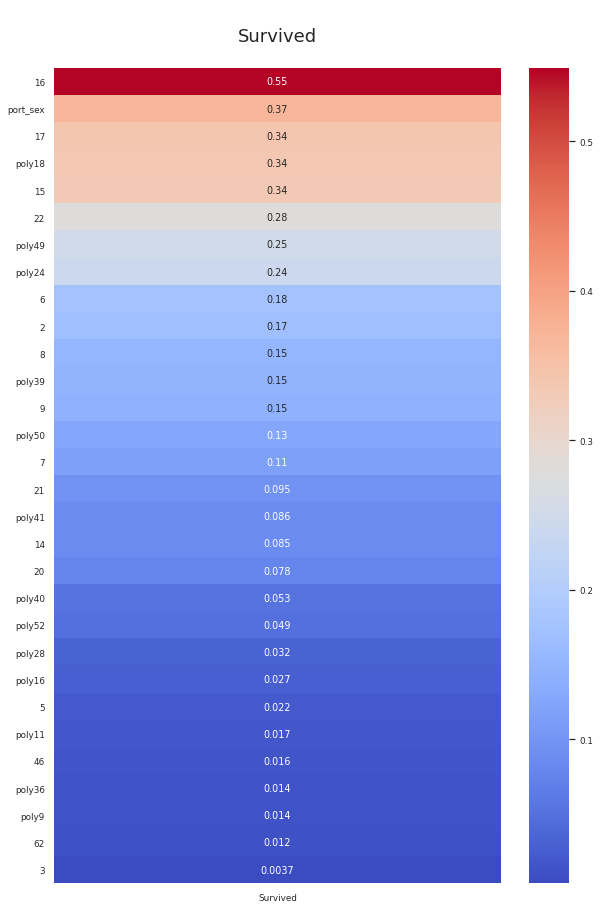

{'14',
 '15',
 '16',
 '17',
 '2',
 '20',
 '21',
 '22',
 '6',
 '7',
 '8',
 '9',
 'Survived',
 'poly18',
 'poly24',
 'poly39',
 'poly40',
 'poly41',
 'poly49',
 'poly50',
 'port_sex'}

In [69]:
##MODULE 3: CORRELATION WITH TARGET

def corr_to_target(dataframe, target, title=None, file=None):
    plt.figure(figsize=(10,15))
    sns.heatmap(dataframe.corr().abs()[[target]].sort_values(target,
                                                        ascending=False)[1:],
                                                        annot=True,
                                                        cmap='coolwarm')
    
    plt.title(f'\n{title}\n', fontsize=18)
    
    plt.show();
    
    return

corr_to_target(df_test, "Survived", title="Survived")


#Removes all feats with correlation under threshold
remove_features = [feat for feat in df_test.columns if df_test.corr().abs()[["Survived"]].loc[feat, :][0] < 0.05]
selected_cols = set(df_test.columns) - set(remove_features)
df_test_2 = df_test[selected_cols]
selected_cols

In [70]:
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier,GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC 
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from catboost import CatBoostClassifier

def run_cv(models, X, y):
    kfold = StratifiedKFold(n_splits= 10) #must be equal to FOLDS
    dict = {"Algorithm":[], "Model_detail":[], "Score":[], 
    "Std_Error": []}
    report = pd.DataFrame(dict)

    for model in models:
        mod = models[model]
        cv_results = cross_val_score(estimator = models[model],
        X= X , y = y, scoring = scoring, cv = kfold)
        report  = report.append({"Algorithm":model,"Model_detail": mod,
         "Score": cv_results.mean(),
            "Std_Error":cv_results.std()}, 
            ignore_index = True)
    print(report[["Algorithm", "Score", "Std_Error"]].sort_values(by = "Score", 
    ascending = False))
    
   

if __name__ == "__main__":
    target = "Survived"
    num_folds = 10
    seed = 42
    X = df_test_2.copy()
    y = X.pop(target)
    scaler = StandardScaler().fit(X)
    XRescaled = scaler.transform(X)
    scoring = "accuracy"
    models =    {
    "decision_tree_gini":tree.DecisionTreeClassifier(criterion= "gini", random_state = 42),
    "decision_tree_entropy": tree.DecisionTreeClassifier(criterion= "entropy",  random_state = 42),
    "RandomForest": RandomForestClassifier(random_state = 42),
    "ExtraTrees": ExtraTreesClassifier(random_state = 42),
    # "GradientBoosting":GradientBoostingClassifier(random_state = 42),
    "CatBoostClassifier": CatBoostClassifier(random_state = 42, verbose = 0),
    'SVM': SVC(),
    'LinearDiscriminant': LinearDiscriminantAnalysis(),
    "KNearest_Neighbour": KNeighborsClassifier(),
    'LogisticRegression': LogisticRegression(max_iter = 40000)}
    print("UNIFIED BASELINE RESULTS:")
    run_cv(models, XRescaled, y)
    

UNIFIED BASELINE RESULTS:
               Algorithm     Score  Std_Error
6     LinearDiscriminant  0.828302   0.030042
4     CatBoostClassifier  0.824931   0.036565
5                    SVM  0.823820   0.035747
7     KNearest_Neighbour  0.822684   0.041615
8     LogisticRegression  0.820449   0.037474
2           RandomForest  0.815968   0.022286
3             ExtraTrees  0.805893   0.037913
1  decision_tree_entropy  0.786816   0.033969
0     decision_tree_gini  0.786804   0.038925


In [59]:
df_test_2.shape

(891, 31)

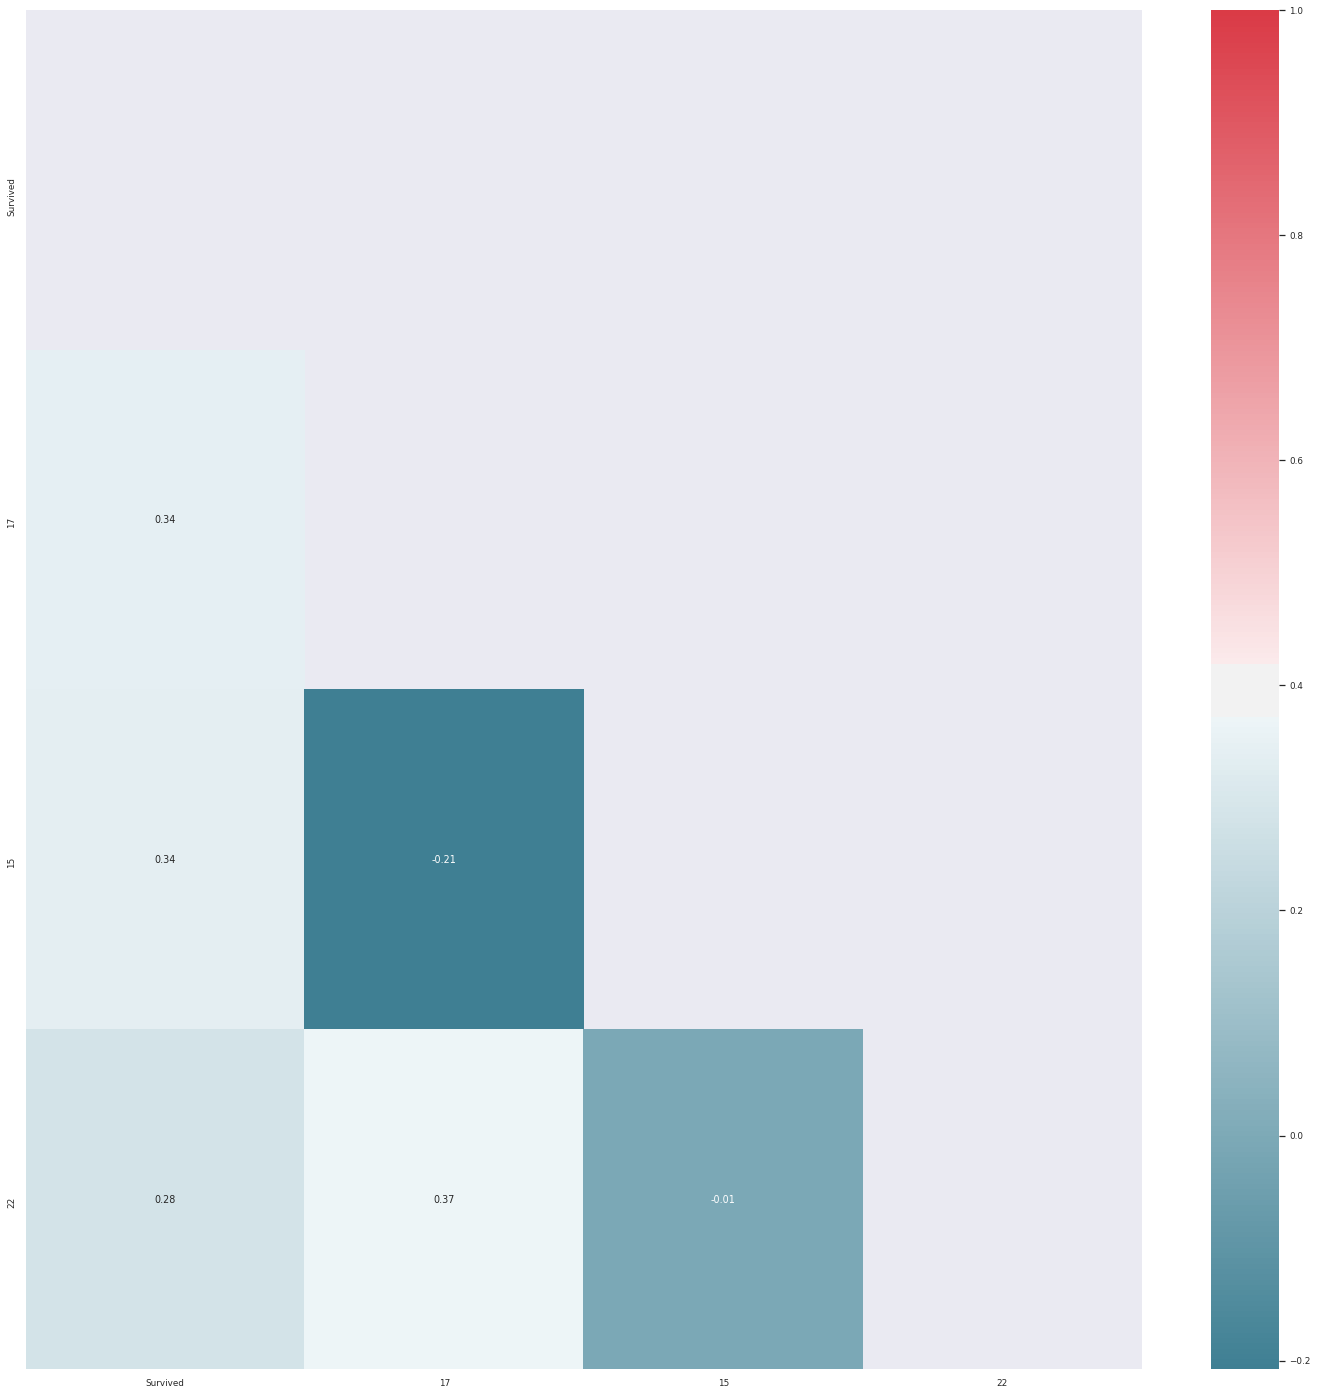

In [71]:
def corr_heat_2(df, target):
    corr = df.corr()
    top_corr_cols = corr[abs((corr[target]) > 0.20)][target].sort_values(ascending = False).keys() #keys is colmns for Series
    top_corr = corr.loc[top_corr_cols, top_corr_cols] #creo una matrix que muestra correlaciones entre los miembros de este subset

    #creating the plot
    dropSelf = np.zeros_like(top_corr) #crea una matrix de zeros con shape igual a top_corr
    dropSelf[np.triu_indices_from(dropSelf)] = True
    plt.figure(figsize = (25,25))
    sns.heatmap(top_corr, cmap = sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f", mask = dropSelf)
    sns.set(font_scale =0.8)
    plt.show()
    

corr_heat_2(df_test_2, target = "Survived")

In [72]:
target = "Survived"
X = df_test_2.copy()
y = X.pop(target)
scaler = StandardScaler().fit(X)
XRescaled = scaler.transform(X)

kfold = StratifiedKFold(n_splits= 10)
mod = CatBoostClassifier(random_state = 42, verbose = 0)
mod_params = {'depth'         : [4,5,6,7,8,9, 10],
                 'learning_rate' : [0.01,0.02,0.03,0.04],
                  'iterations'    : [10, 20,30,40,50,60,70,80,90, 100]
                 }
gs_mod = GridSearchCV(mod, param_grid = mod_params, cv = kfold,
         scoring = "accuracy",
                        n_jobs = -1, verbose = 0)
gs_mod.fit(XRescaled, y)
gs_best = gs_mod.best_estimator_
print("Best Score:", gs_mod.best_score_)
print("Standard error in test set:", gs_mod.cv_results_["std_test_score"].mean())


/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Best Score: 0.8372908863920101


In [73]:
gs_mod.cv_results_["std_test_score"].mean()

0.036341328118628675